In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# 2.Load Dataset
data = pd.read_csv("viettri_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,44,17,29,2,9,4
1,3/2/2019,65,37,27,4,12,4
2,3/3/2019,81,38,2,1,1,2
3,3/4/2019,51,24,21,4,8,1
4,3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...,...
1915,5/28/2024,38,24,35,1,15,5
1916,5/29/2024,38,17,41,7,15,10
1917,5/30/2024,28,8,11,1,15,1
1918,5/31/2024,12,12,16,1,16,7


In [3]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1920 non-null   object
 1   pm25    1920 non-null   int64 
 2   pm10    1920 non-null   int64 
 3   o3      1920 non-null   int64 
 4   no2     1920 non-null   int64 
 5   so2     1920 non-null   int64 
 6   co      1920 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,42.395313,22.470833,17.391667,7.528125,9.497917,3.961979
std,31.665288,16.124166,12.907283,4.971229,6.526731,2.516048
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,19.000000,10.000000,8.750000,3.000000,4.000000,2.000000
50%,35.000000,20.000000,15.000000,7.000000,9.000000,4.000000
75%,59.000000,32.000000,24.000000,11.000000,14.000000,6.000000
max,178.000000,94.000000,114.000000,35.000000,27.000000,22.000000


In [4]:
#Chọn thuộc tính
data = data[['pm25','pm10']]
data = data.dropna() 
data = data.reset_index(drop=True) 
data

,pm25,pm10
0,44,17
1,65,37
2,81,38
3,51,24
4,43,7
...,...,...
1915,38,24
1916,38,17
1917,28,8
1918,12,12


In [5]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)
    
    return forecast_smoothed_filled

# Example usage
data = smoothed(data)

<Axes: >

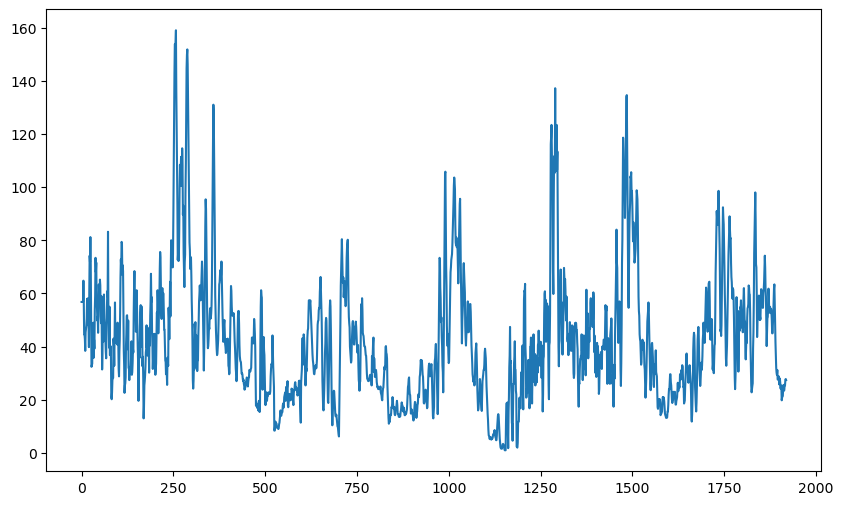

In [6]:
data['pm25'].plot(figsize=(10,6))

In [7]:
# Split the data into training, testing
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [8]:
# 3. Quá trình Training
model = VAR(train_data)
model_fitted = model.fit(maxlags =15 , ic='aic')

In [9]:
# 4. Quá trình testing 
# Dự đoán cho cả 'pm25' và 'pm10'
y_pred = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=len(test_data))


In [10]:
y_pred = pd.DataFrame(y_pred, columns=['pm25', 'pm10'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [11]:
y_pred

array([[56.73119626, 27.78306289],
       [56.73119626, 27.78306289],
       [56.73119626, 27.78306289],
       ...,
       [40.67987095, 20.25484518],
       [40.67987079, 20.2548451 ],
       [40.67987064, 20.25484502]])

In [12]:

# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index = data.index[-1]

# # Dự đoán cho 90 ngày tiếp theo
y_next_90_days = model_fitted.forecast(data.values[-model_fitted.k_ar:], steps=90)



# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)



Predicted closing prices for the next 90 days:
[[28.9141419  17.66059147]
 [29.59622911 17.13060843]
 [28.81082422 17.92259072]
 [30.49043575 18.47172262]
 [32.45595578 17.41371942]
 [31.56603855 17.33163622]
 [32.11286591 17.25902146]
 [32.83909021 16.75513568]
 [31.91309707 16.51421524]
 [31.63679568 16.80330368]
 [32.39966139 16.84763202]
 [32.18225152 16.95876641]
 [32.48805615 16.98764238]
 [33.31734768 16.91478434]
 [33.20942459 17.07096894]
 [33.38029763 17.09399102]
 [33.88778084 17.07298461]
 [33.78710874 17.19558326]
 [33.99252484 17.36781223]
 [34.53034795 17.27244036]
 [34.61852882 17.30066615]
 [34.73363416 17.39018367]
 [35.10884978 17.43999887]
 [35.00205065 17.44153772]
 [35.05583581 17.53728933]
 [35.27181841 17.63194731]
 [35.33733785 17.6661722 ]
 [35.45446593 17.68857393]
 [35.76457114 17.7456827 ]
 [35.85863419 17.81066815]
 [35.94286772 17.8340236 ]
 [36.12807862 17.88828724]
 [36.1760975  17.94641483]
 [36.26239422 18.01006089]
 [36.40639393 18.04396039]
 [36.538

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính RMSE
rmse = np.sqrt(mean_squared_error(test_data['pm25'], y_pred[:, 0]))
print('Testing RMSE:', rmse)

# Tính MAE
mae = mean_absolute_error(test_data['pm25'], y_pred[:, 0])
print('\nTesting MAE:', mae)

# Tính MAPE
mape = np.mean(np.abs((test_data['pm25'] - y_pred[:, 0]) / test_data['pm25'])) * 100
print('\nTesting MAPE:', mape)


Testing RMSE: 22.72225197841468

Testing MAE: 17.041472350630883

Testing MAPE: 42.6608241039545


In [14]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

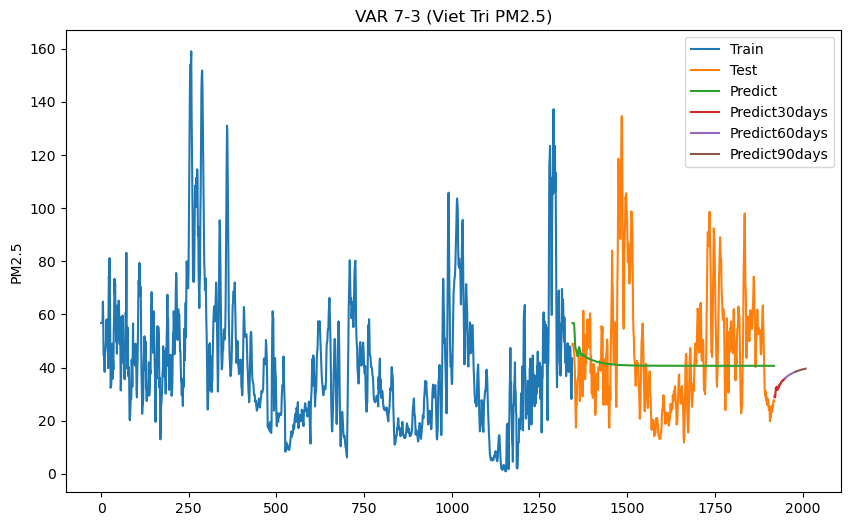

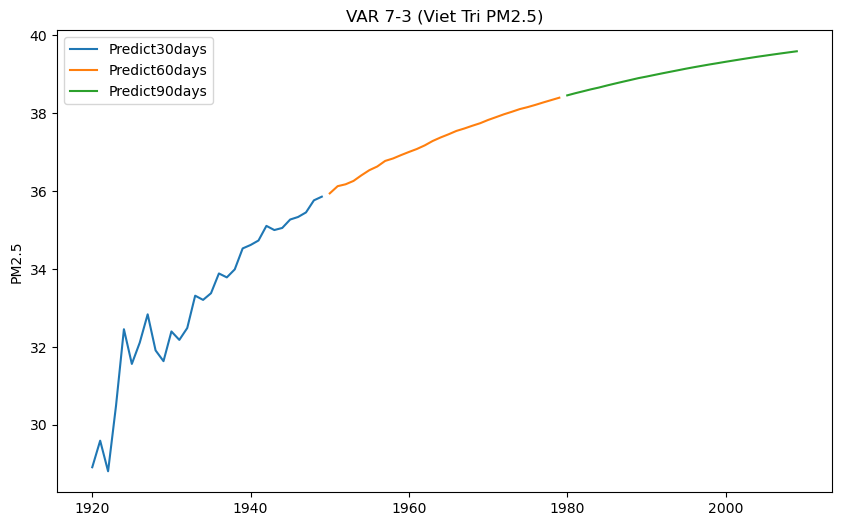

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử last_index và y_next_90_days đã được định nghĩa trước đó
# Bạn có thể thay thế chúng bằng dữ liệu thực tế của mình

# Vẽ biểu đồ huấn luyện và kiểm tra với dự đoán
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['pm25'], label='Train')
plt.plot(test_data.index, test_data['pm25'], label='Test')
plt.plot(test_data.index, y_pred[:, 0], label='Predict')

# Vẽ dự đoán 90 ngày
last_index = data.index[-1]  # Giả sử last_index là index cuối cùng của train_data

last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

# Vẽ dự đoán 90 ngày với kích thước 14x7
plt.figure(figsize=(10, 6))
last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()
